In [1]:
%matplotlib inline
from IPython.display import Image, display
import numpy as np
import tensorflow as tf

import vgg19
from loss import gram_matrix
from images import load_image, add_one_dim, image_big

In [2]:
model_file_path = "vgg19/vgg19.mat"
net = vgg19.VGG19(model_file_path)

In [3]:
content_filename = 'data/content/dolphins.jpg'
content_image = load_image(content_filename, max_size=None)
content_image = add_one_dim(content_image)

style_filename = 'data/styles/random-art.jpg'
style_image = load_image(style_filename, max_size=300)
style_image = add_one_dim(style_image)

In [4]:
init_image = np.random.normal(size=content_image.shape, scale=np.std(content_image))

In [5]:
content_layers = ['conv4_2']
style_layers = ['relu1_1', 'relu2_1', 'relu3_1', 'relu4_1', 'relu5_1']

In [6]:
content_weight = 1.0
style_weight = 0.2
denoise_weight = 0.001

In [7]:
sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True))

In [8]:
x0 = np.float32(net.preprocess(init_image))
x = tf.Variable(x0, trainable=True, dtype=tf.float32)

p0 = np.float32(net.preprocess(content_image))
p = tf.placeholder(tf.float32, shape=p0.shape, name='content')

a0 = np.float32(net.preprocess(style_image))
a = tf.placeholder(tf.float32, shape=a0.shape, name='style')

In [9]:
content_activations = net.feed_forward(p, scope='content')
Ps = [content_activations[id] for id in content_layers]
print(Ps)

[<tf.Tensor 'content_1/BiasAdd_9:0' shape=(1, 45, 80, 512) dtype=float32>]


In [10]:
style_activations = net.feed_forward(a, scope='style')
As = [style_activations[id] for id in style_layers]
print(As)

[<tf.Tensor 'style_1/Relu:0' shape=(1, 300, 225, 64) dtype=float32>, <tf.Tensor 'style_1/Relu_2:0' shape=(1, 150, 113, 128) dtype=float32>, <tf.Tensor 'style_1/Relu_4:0' shape=(1, 75, 57, 256) dtype=float32>, <tf.Tensor 'style_1/Relu_8:0' shape=(1, 38, 29, 512) dtype=float32>, <tf.Tensor 'style_1/Relu_12:0' shape=(1, 19, 15, 512) dtype=float32>]


In [11]:
res_img_activations = net.feed_forward(x, scope='mixed')
Xs_content = [res_img_activations[id] for id in content_layers]
Xs_style = [res_img_activations[id] for id in style_layers]
print(Xs_content)

[<tf.Tensor 'mixed/BiasAdd_9:0' shape=(1, 45, 80, 512) dtype=float32>]


In [12]:
loss_content = 0
loss_style = 0

In [13]:
for i in range(0, len(content_layers)):
    X = Xs_content[i]
    P = Ps[i]
    
    _, h, w, d = X.get_shape() # first value is batch size
    loss_content += content_weight * tf.reduce_sum(tf.pow((X - P), 2)) / 2

In [14]:
for i in range(0, len(style_layers)):
    X = Xs_style[i]
    A = As[i]
    
    _, h, w, d = X.get_shape()
    N = h.value * w.value       # product of width and height
    M = d.value                 # number of filters
    
    X_gram = gram_matrix(X)
    A_gram = gram_matrix(A)
    
    loss_style += style_weight * (1. / (4 * N ** 2 * M ** 2)) * tf.reduce_sum(tf.pow((X_gram - A_gram), 2))

In [15]:
loss = loss_content + loss_style

In [52]:
optimizer = tf.contrib.opt.ScipyOptimizerInterface(
    loss, 
    method='L-BFGS-B', 
    options={'maxiter': 10}
)

In [53]:
init_op = tf.global_variables_initializer()
sess.run(init_op)

In [55]:
optimizer.minimize(
    sess,
    feed_dict={a:a0, p:p0},
    fetches=[loss, loss_content, loss_style]
)

final_image = sess.run(x)
final_image = np.clip(net.undo_preprocess(final_image), 0.0, 255.0)

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
  Objective function value: 2242808119296.000000
  Number of iterations: 11
  Number of functions evaluations: 18


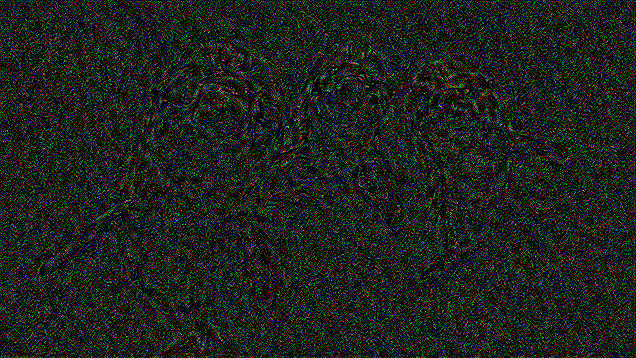

In [57]:
image_big(final_image[0])